# Introduction

Looking at how Ice Cuber's solution tackles the problems.

In [2]:
import numpy as np
import json
from glob import glob
from pathlib import Path
import os
import random
import matplotlib.pyplot as plt
from   matplotlib import colors

from subprocess import Popen, PIPE, STDOUT
from glob import glob

# Helper Functions

In [3]:
def get_gridfile_as_numpy( imagefile ):
    """ convert the specified CSV file, containing a grid, to a numpy array """
    with open(imagefile, 'r') as file:
        data = file.read()

    arr = []
    rows = data.split('\n')
    for row in rows:
        list_of_integers = [int(item) for item in row.split(',')]
        arr.append(list_of_integers)

    return np.array(arr)

In [5]:
def mySystem(cmd):
    print(cmd)
    process = Popen(cmd, stdout=PIPE, stderr=STDOUT, shell=True)
    for line in iter(process.stdout.readline, b''):
        print(line.decode("utf-8"), end='')
    assert(process.wait() == 0)   

In [6]:
def load_json(fpath):
    with open(fpath) as f:
        data = json.load(f)
    return data

In [7]:
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
      '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

In [8]:
# adapted from: https://www.kaggle.com/code/allegich/arc-2024-starter-notebook-eda
def plot_one(task, ax, i,train_or_test, input_or_output):

    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+input_or_output)

In [9]:
def show_attempts( train_id ):

  data = load_json('sub_icecube.json')
  
  n_samples = 2

  name = f'attempt_2'
  input_matrix = data[train_id][0][name]
  if len(input_matrix) > 0:
    fig, axs = plt.subplots(1, n_samples, figsize=(3*n_samples,3*2))
    for i in range(n_samples):  

      name = f'attempt_{i+1}'
      input_matrix = data[train_id][0][name]
      if len(input_matrix) > 0 :
      
        ax = axs[i]
        ax.imshow(input_matrix, cmap=cmap, norm=norm)
        ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    

        ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
        ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(f"{train_id} - {name}")
        
    plt.tight_layout()
    plt.show()

  else:
    print("Only 1 attempt")
    fig, axs = plt.subplots(1, 1, figsize=(2,2))
    plot_one(data, axs, 0, train_id, 'attempt_1')
    plt.show()  
    

In [10]:
def plot_sample(sample,train_id):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    n_samples = len(sample['train'])
    print('n samples', n_samples)
    print('train id %s, n_colors %s, shape in %s shape out %s'  
              %(train_id, len(np.unique(sample['train'][0]['input']))-1,
               np.array(sample['train'][0]['input']).shape,
               np.array(sample['train'][0]['output']).shape))
    
    fig, axs = plt.subplots(2, n_samples, figsize=(3*n_samples,3*2))
    for i in range(n_samples):  
        plot_one(sample, axs[0,i],i,'train','input')
        plot_one(sample, axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()
    
    print('test img colors %s, shape %s'% (np.unique(sample['test'][0]['input']),
        np.array(sample['test'][0]['input']).shape))
    fig, axs = plt.subplots(1, 1, figsize=(2,2))
    plot_one(sample, axs, 0, 'test', 'input')
    plt.show()

In [11]:
def plot_single(grid_array,title):
    """
    Plots the supplied grid    
    """        
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
        
    input_matrix = grid_array
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    

    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title)

    plt.show()

In [12]:
# Function to translate from old submission format (csv) to new one (json)
def translate_submission(file_path):
    # Read the original submission file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    submission_dict = {}

    for line in lines[1:]:  # Skip the header line
        output_id, output = line.strip().split(',')
        task_id, output_idx = output_id.split('_')
        predictions = output.split(' ')  # Split predictions based on ' '
        
        # Take only the first two predictions
        if len(predictions) > 2:
            predictions = predictions[:2]

        processed_predictions = []
        for pred in predictions:
            if pred:  # Check if pred is not an empty string
                pred_lines = pred.split('|')[1:-1]  # Remove empty strings from split
                pred_matrix = [list(map(int, line)) for line in pred_lines]
                processed_predictions.append(pred_matrix)

        attempt_1 = processed_predictions[0] if len(processed_predictions) > 0 else []
        attempt_2 = processed_predictions[1] if len(processed_predictions) > 1 else []

        if task_id not in submission_dict:
            submission_dict[task_id] = []

        attempt_dict = {
            "attempt_1": attempt_1,
            "attempt_2": attempt_2
        }

        if output_idx == '0':
            submission_dict[task_id].insert(0, attempt_dict)
        else:
            submission_dict[task_id].append(attempt_dict)
    
    # Write to the new json file
    with open('sub_icecube.json', 'w') as file:
        json.dump(submission_dict, file, indent=4)

# Test Some Example Problems

### Problem 1
Result: Fail

In [12]:
train_id = '0a938d79'
filepath = f"dataset/training/{train_id}.json"

mySystem(f"cd ..; python3 safe_run.py {filepath} 1")
mySystem("cp ../submission_part.csv old_submission.csv")

cd ..; python3 safe_run.py dataset/training/0a938d79.json 1
make: 'run' is up to date.
make: 'count_tasks' is up to date.
Number of args = 3
Argument 1 = dataset/training/0a938d79.json - integer = False
File path = dataset/training/0a938d79.json
File name = 0a938d79
./run dataset/training/0a938d79.json 3
SUCCESS ./run dataset/training/0a938d79.json 3  8.5s 133MB
File name = 0a938d79
./run dataset/training/0a938d79.json 23
SUCCESS ./run dataset/training/0a938d79.json 23  21.6s 247MB
File name = 0a938d79
./run dataset/training/0a938d79.json 33
SUCCESS ./run dataset/training/0a938d79.json 33  24.5s 255MB
cp ../submission_part.csv old_submission.csv


n samples 4
train id 0a938d79, n_colors 2, shape in (10, 25) shape out (10, 25)


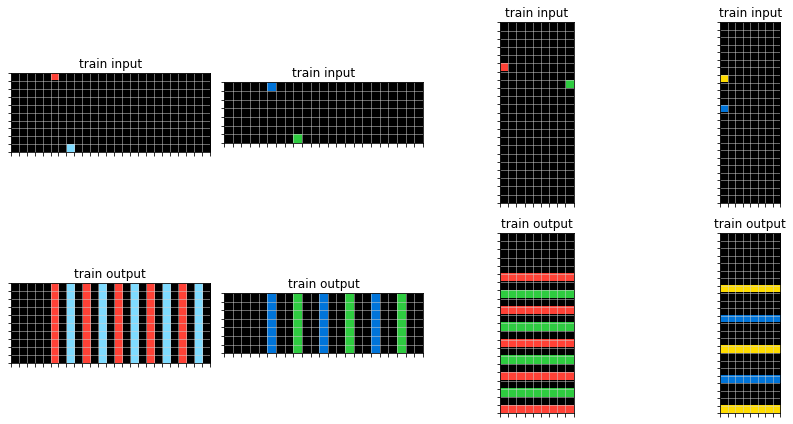

test img colors [0 3 4], shape (11, 27)


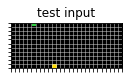

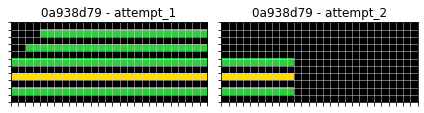

In [13]:
translate_submission('old_submission.csv')

# load and display the predictions
data = load_json('../' + filepath)
plot_sample(data, train_id)
show_attempts( train_id )

## Analysis of IceCuber Steps

1. Normalises - shifts all colour indexes down, so they are a continuous range starting at 1 e.g. if the grid contains 4 and 7, these will be normalised to 1 and 2

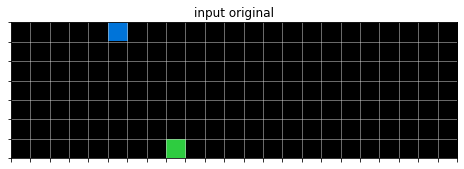

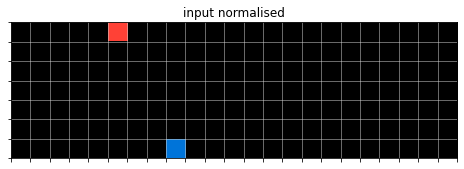

In [14]:
imagefile = "../store/tmp/s_train_first.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"input original")

imagefile = "../store/tmp/train_first.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"input normalised")

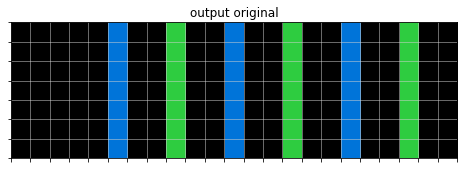

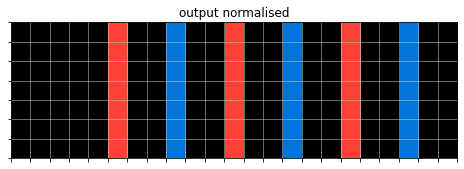

In [15]:
imagefile = "../store/tmp/s_train_second.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"output original")

imagefile = "../store/tmp/train_second.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"output normalised")

### Problem 2
Result: Fail

In [16]:
train_id = 'a61ba2ce'
filepath = f"dataset/training/{train_id}.json"

mySystem(f"cd ..; python3 safe_run.py {filepath} 1")
mySystem("cp ../submission_part.csv old_submission.csv")

cd ..; python3 safe_run.py dataset/training/a61ba2ce.json 1
make: 'run' is up to date.
make: 'count_tasks' is up to date.
Number of args = 3
Argument 1 = dataset/training/a61ba2ce.json - integer = False
File path = dataset/training/a61ba2ce.json
File name = a61ba2ce
./run dataset/training/a61ba2ce.json 3
SUCCESS ./run dataset/training/a61ba2ce.json 3  5.0s 166MB
File name = a61ba2ce
./run dataset/training/a61ba2ce.json 23
SUCCESS ./run dataset/training/a61ba2ce.json 23  9.1s 266MB
File name = a61ba2ce
./run dataset/training/a61ba2ce.json 33
SUCCESS ./run dataset/training/a61ba2ce.json 33  8.9s 267MB
cp ../submission_part.csv old_submission.csv


n samples 2
train id a61ba2ce, n_colors 4, shape in (13, 13) shape out (4, 4)


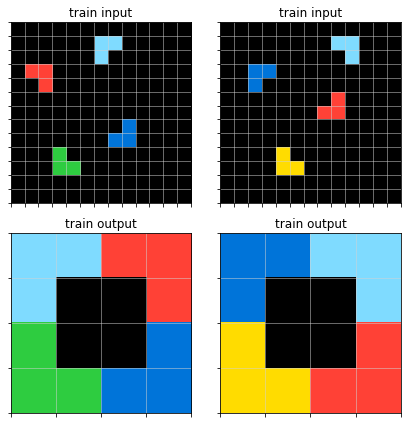

test img colors [0 1 3 6 8], shape (13, 13)


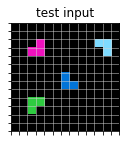

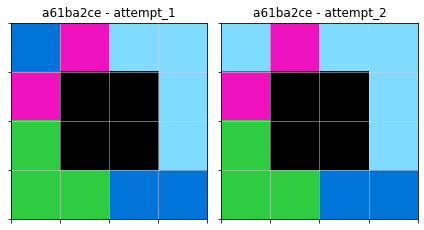

In [17]:
translate_submission('old_submission.csv')

# load and display the predictions
data = load_json('../' + filepath)
plot_sample(data, train_id)
show_attempts( train_id )

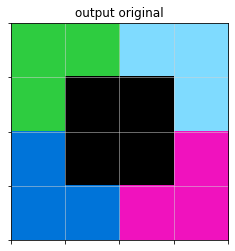

In [15]:
imagefile = "../store/tmp/test_out.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"output original")

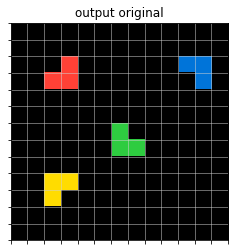

In [17]:
imagefile = "../store/tmp/test_first.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"output original")

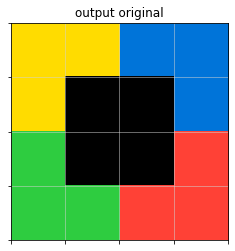

In [16]:
imagefile = "../store/tmp/test_second.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"output original")

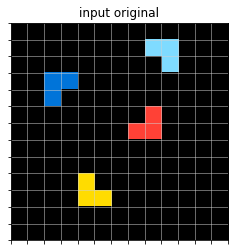

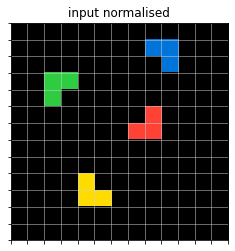

In [18]:
imagefile = "../store/tmp/s_train_first.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"input original")

imagefile = "../store/tmp/train_first.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"input normalised")

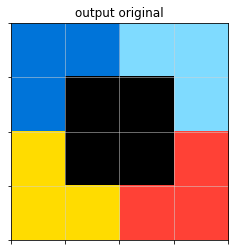

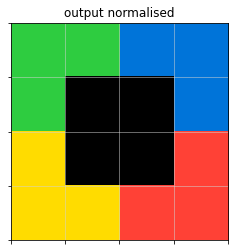

In [19]:
imagefile = "../store/tmp/s_train_second.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"output original")

imagefile = "../store/tmp/train_second.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"output normalised")

### Problem 3

Result: Pass

In [21]:
train_id = '0b148d64'
filepath = f"dataset/training/{train_id}.json"

mySystem(f"cd ..; python3 safe_run.py {filepath} 1")
mySystem("cp ../submission_part.csv old_submission.csv")

cd ..; python3 safe_run.py dataset/training/0b148d64.json 1
make: 'run' is up to date.
make: 'count_tasks' is up to date.
Number of args = 3
Argument 1 = dataset/training/0b148d64.json - integer = False
File path = dataset/training/0b148d64.json
File name = 0b148d64
./run dataset/training/0b148d64.json 3
SUCCESS ./run dataset/training/0b148d64.json 3  13.0s 211MB
File name = 0b148d64
./run dataset/training/0b148d64.json 23
SUCCESS ./run dataset/training/0b148d64.json 23  27.6s 371MB
File name = 0b148d64
./run dataset/training/0b148d64.json 33
SUCCESS ./run dataset/training/0b148d64.json 33  27.2s 370MB
cp ../submission_part.csv old_submission.csv


n samples 3
train id 0b148d64, n_colors 2, shape in (21, 21) shape out (10, 10)


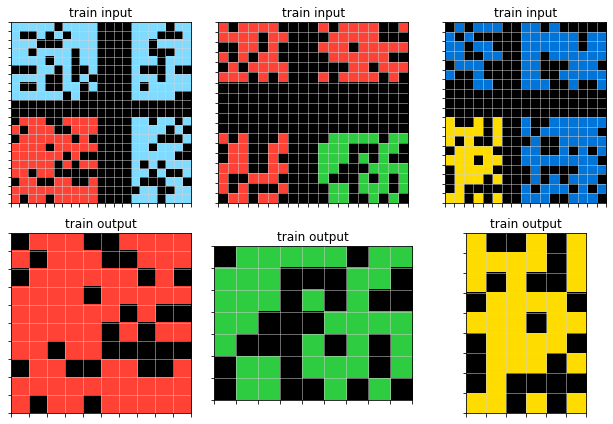

test img colors [0 1 3], shape (15, 17)


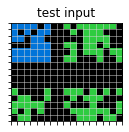

Only 1 attempt


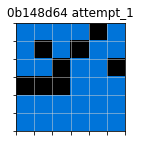

In [22]:
translate_submission('old_submission.csv')

# load and display the predictions
data = load_json('../' + filepath)
plot_sample(data, train_id)
show_attempts( train_id )

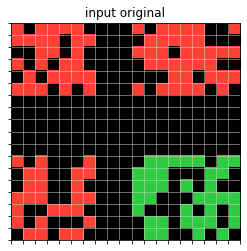

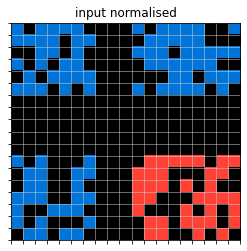

In [23]:
imagefile = "../store/tmp/s_train_first.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"input original")

imagefile = "../store/tmp/train_first.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"input normalised")

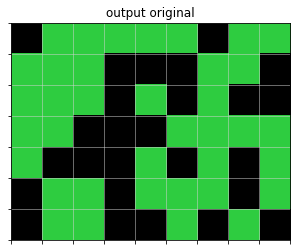

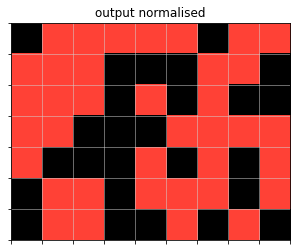

In [24]:
imagefile = "../store/tmp/s_train_second.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"output original")

imagefile = "../store/tmp/train_second.csv"
grid_array = get_gridfile_as_numpy( imagefile )
plot_single(grid_array,"output normalised")